In [104]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as XGB
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sets import Set
import math
%matplotlib inline


/Users/aviv.r/workspace/kaggel_hous_prices/venv/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: the sets module is deprecated


In [254]:
def years_since_built(df):
    df["YearSinceBuilt"] = df["YrSold"] - df["YearBuilt"]


In [255]:
def years_since_remodAdd(df):
    df["YearSinceRemodAdd"] = df["YrSold"] - df["YearRemodAdd"]

In [262]:
def compute_years_and_was_remodAdd(df):
    years_since_remodAdd(df)
    def check_remodAdd (row):
        if row['YearSinceRemodAdd'] > 0 :
            return '1'
        return '0'
    df["wasRemodAdd"] = df.apply (lambda row: check_remodAdd (row),axis=1).astype(int)


In [5]:
def create_total_sf(df):
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF'] 
    

In [6]:
def standardize_numerical_features(df,feature_list):
    for feature in feature_list:
        feature_series= df.loc[:,feature]
        df.loc[:,feature] = (feature_series - feature_series.mean())/feature_series.std()

In [245]:
def one_hot_categorical(df,categorical_features):
    dummy_variables = []
    for feature in categorical_features:
        one_hot = pd.get_dummies(df[[feature]].astype(str))
        dummy_variables.extend(list(one_hot))
        df = pd.concat([df, one_hot], axis=1)
    return df, dummy_variables

In [527]:
#Loading data
all_data = pd.read_csv('train.csv')

#Declaring features
numerical_features = ['TotalSF',"GrLivArea",'YearSinceRemodAdd','YearSinceBuilt','TotRmsAbvGrd', 'GarageCars',
                      'OverallQual','FullBath']
categorical_features = ['MSSubClass','MSZoning','Street','LotShape','MasVnrType','Fence']
binary_features = ['wasRemodAdd']
#feature engineering

create_total_sf(all_data)
years_since_built(all_data)
compute_years_and_was_remodAdd(all_data)

all_data['TotalSF'] = np.log(all_data['TotalSF'])
all_data.loc[(all_data["MasVnrType"].isnull()), "MasVnrType"] = 'None'
all_data.loc[(all_data["Fence"].isnull()), "Fence"] = 'NoFence'
all_data.loc[(all_data["Fence"].isnull()), "Fence"] = 'NoFence'



standardize_numerical_features(all_data,numerical_features)
all_data, dummy_variables = one_hot_categorical(all_data,categorical_features)



#splitting data
features = numerical_features + dummy_variables + binary_features
y = np.log(all_data.pop('SalePrice'))
X = all_data[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,
                                                    stratify=all_data[categorical_features])


In [528]:
#train model
estimator = XGB.XGBRegressor(seed=42, max_depth=6, n_estimators=300, learning_rate = 0.15,
                             gamma = 0.8,subsample=0.8,colsample_bytree=0.4)
model = estimator.fit(X_train,y_train)
print math.sqrt((mean_squared_error(y_test, model.predict(X_test))))
print (model)



0.138770920787
XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.4,
       gamma=0.8, learning_rate=0.15, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=300, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=42, silent=True, subsample=0.8)


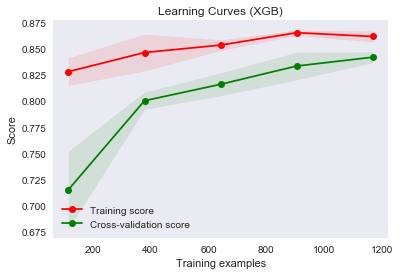

In [529]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

title = "Learning Curves (XGB)"
plt.figure()
plt.title(title)
plt.xlabel("Training examples")
plt.ylabel("Score")
train_sizes, train_scores, test_scores = learning_curve(
   estimator, X, y, cv=cv, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")



In [491]:
#Test evaluation
#Loading data
all_data = pd.read_csv('test.csv')


#Declaring features
numerical_features = ['TotalSF',"GrLivArea",'YearSinceRemodAdd','YearSinceBuilt']
categorical_features = ['MSSubClass','MSZoning']
binary_features = ['wasRemodAdd']
#feature engineering
create_total_sf(all_data)
years_since_built(all_data)
compute_years_and_was_remodAdd(all_data)
standardize_numerical_features(all_data,numerical_features)
all_data, dummy_variables = one_hot_categorical(all_data,categorical_features)

no_train_features = list(set(test_features) - set(features))

X = all_data[features]
#predicting
all_data['SalePrice'] = np.exp(model.predict(X))
all_data.loc[:,['Id','SalePrice']].to_csv('result.csv', header=True,index=False)

KeyError: "['Street_Grvl' 'Street_Pave' 'LotShape_IR1' 'LotShape_IR2' 'LotShape_IR3'\n 'LotShape_Reg' 'MasVnrType_BrkCmn' 'MasVnrType_BrkFace' 'MasVnrType_None'\n 'MasVnrType_Stone'] not in index"